# SEP Pitch-angle distribution and first-order anisotropies

In [1]:
from anisotropy import run_SEPevent, select_sc_inst
import datetime as dt
import numpy as np
import os
import pandas as pd

### Select a local folder to save the downloaded data and output plots

In [2]:
# directory for saving data files
path = os.getcwd()+os.sep+'data'

# directory for saving plots
plot_folder = os.getcwd()+os.sep+'plots'

### Select Spacecraft & Instrument, particle species, and energy channel

In [3]:
spacecraft_instrument = select_sc_inst()

RadioButtons(description='Spacecraft & instrument:', index=4, layout=Layout(width='max-content'), options=('So…

In [4]:
species = "e"
channels = 3  # no channel averaging implemented for 3DP!
averaging = "2min"  # data averaging

Information on available energy channels for the selected instrument are shown in the output below. Run it once with an arbitrary selection to get the information, then update the selection here, and run it again.

# Set data loading and plotting window

Spacecraft: STEREO A
Instrument: SEPT. Species: e. Channels: 3.

Available energy channels:
channel
2       45.0-55.0 keV
3       55.0-65.0 keV
4       65.0-75.0 keV
5       75.0-85.0 keV
6      85.0-105.0 keV
7     105.0-125.0 keV
8     125.0-145.0 keV
9     145.0-165.0 keV
10    165.0-195.0 keV
11    195.0-225.0 keV
12    225.0-255.0 keV
13    255.0-295.0 keV
14    295.0-335.0 keV
15    335.0-375.0 keV
16    375.0-425.0 keV
Name: ch_strings, dtype: object

Loading MAG...
RED = INWARD, negative polarity, [90, 270] degrees
BLUE = OUTWARD, positive polarity, [270, 360] and [0, 90] degrees
Calculating PA coverage.


  0%|          | 0/780 [00:00<?, ?it/s]

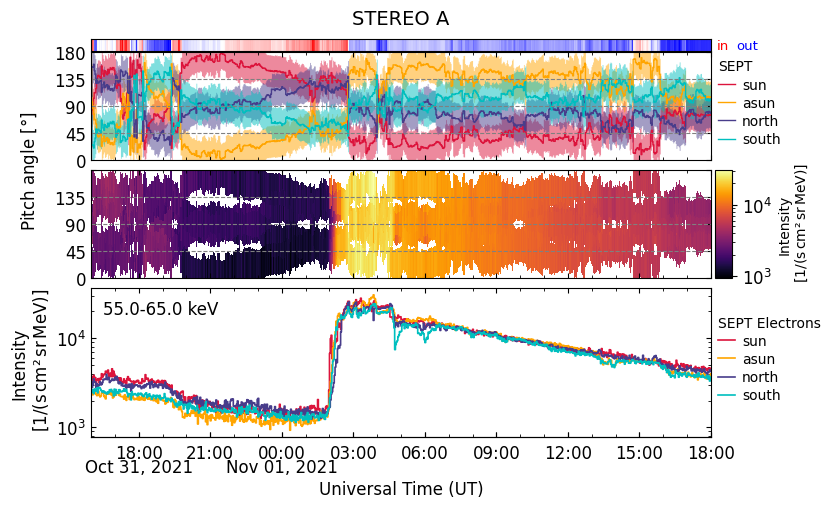

In [5]:
start_time = pd.to_datetime('2021-10-31 16:00:00')
end_time = pd.to_datetime('2021-11-01 18:00:00')

event = run_SEPevent(path, plot_folder, spacecraft_instrument.value, start_time, end_time, species=species, channels=channels, averaging=averaging)
fig, axes = event.overview_plot()

# Background analysis and subtraction
#### Choose a background window!
To determine the (potentially time-dependent) intensity background we fit both, a constant and an exponentially decaying model to the sector-averaged background intensity. We chose the better fit based on the reduded chi-squares. Then the model is extrapolated in time subtracted from the measured intensities.

Background window start: 2021-10-31 23:00:00
Background window end: 2021-11-01 01:30:00
Background correction window end: 2021-11-01 04:30:00
Reduced chi-squared (constant model): 5.04
Reduced chi-squared (exponential model): 5.06


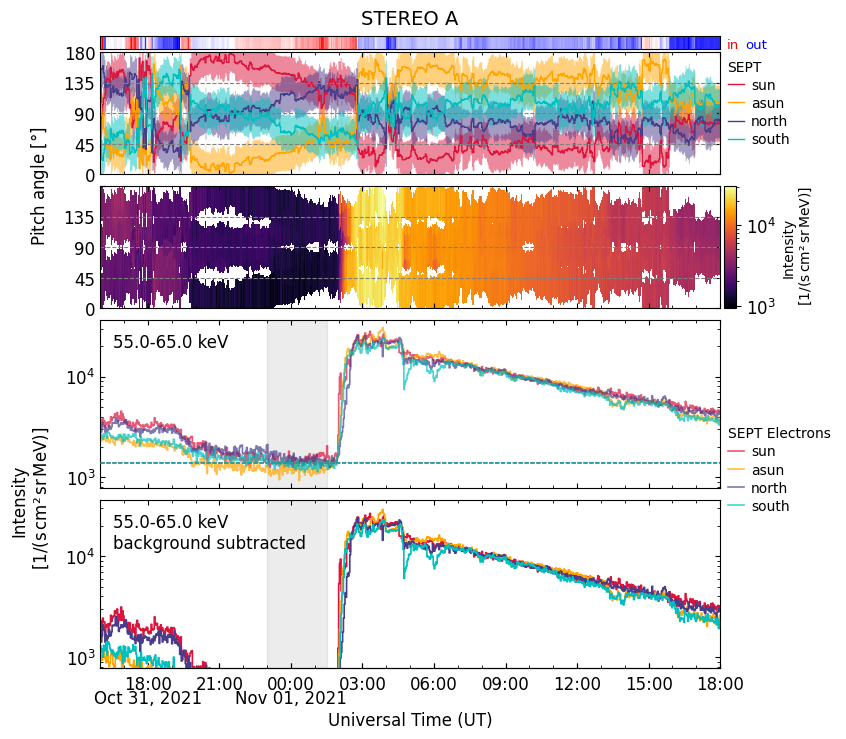

In [6]:
# chose a background window. Setting these to None will set default window [start_time, start_time + 5 hours] 
bg_start = pd.to_datetime('2021-10-31 23:00:00')  # None
bg_end =  pd.to_datetime('2021-11-01 01:30:00')  # None

# chose an end time for the background subtraction:
# if None then background subraction stops 3 hours after the end of the background window (bg_end)
corr_window_end = None  # pd.to_datetime('2021-11-01 18:00:00') 

# resets background window and event.corr_window_end which is used to check that the background is not above the observations near the event start
event.set_background_window(bg_start, bg_end, corr_window_end)

# averaging (in minutes) used for the background analysis
bg_av_min = 10  

event.background_analysis_all(minutes=bg_av_min)
fig, axes = event.overview_plot_bgsub()

# Determine Anisotropies

Anisotropies are determined with and without background subtraction. 

### Choose the method for anisotropy calculation: 
- weighted-sum method (strongly suggested for if only 4 viewing directions are available). The weighted-sum method is described in Brüdern et al. 2018, Central European Astrophysical Bulletin, 42, 2.

  
- weighted-sum method including bootstrapping: provides uncertainties for the anisotropy based on bootstrapping within intensity uncertainty ranges

- fit method: pitch-angle distributions are fitted with 2nd-order Legendre Polionomials to determine the anisotropy


Note that anisotropies during noisy low-intensity intervals (like right before the SEP event) cannot be trusted.

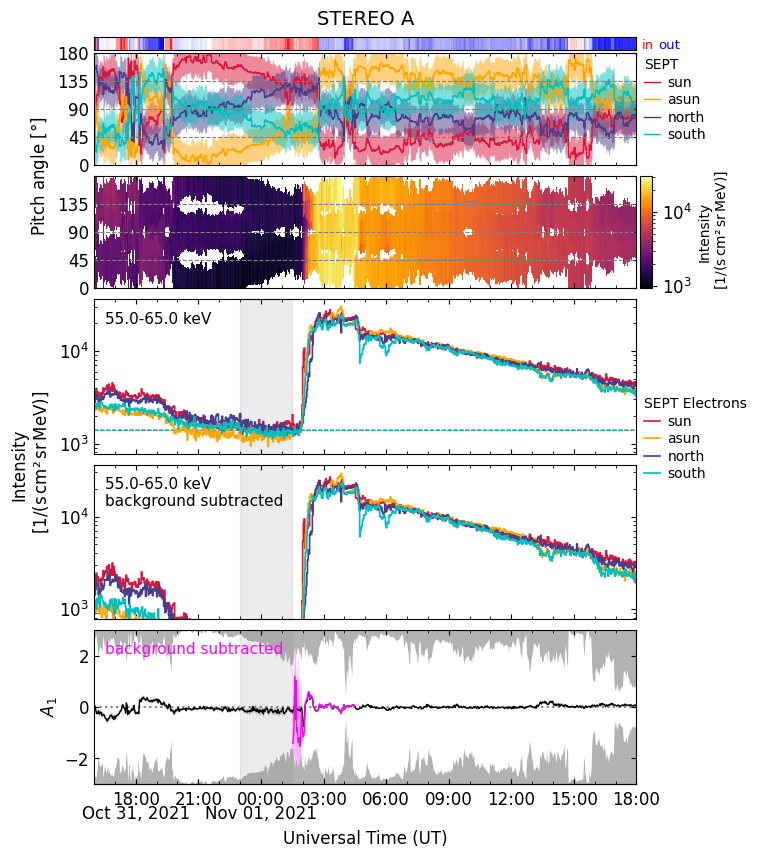

In [7]:
ani_method = 'weighted_sum_bootstrap'  # 'weighted_sum', 'weighted_sum_bootstrap', or 'fit'; 'weighted_sum_bootstrap' not available for Wind

event.calculate_anisotropy(ani_method=ani_method)
fig, axes = event.anisotropy_plot(ani_method=ani_method, savefig=True)    

### Plot explanations: 

#### Anisotropy panel:

First order anisotropies without (black) and with (magenta) background subtraction. 
Gray and magenta shades aroung the anisotropy lines show the anisotropy uncertainty based 2.5 and 95 percentiles resulting on a bootstrapping analysis based on counting rate statistics (and the background subtraction - magenta trace) (only shown when `ani_method='weighted_sum_bootstrap'`).

Gray shades at the top and bottom of the panel show anisotropy values that cannot be determined with the instrument's pitch-angle coverage at that time.

----------------------
#### Plarity bar at the top of the plot marks the magnetic field polarity:

RED = INWARD, negative polarity, [90, 270] degrees

BLUE = OUTWARD, positive polarity, [270, 360] and [0, 90] degrees